In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import StratifiedKFold
from HTMLFeatures import HTMLFeatures
from xgboost import XGBClassifier, plot_importance
from skopt import BayesSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, roc_curve, precision_recall_curve, 
                             confusion_matrix, ConfusionMatrixDisplay)

# **HTML Analysis**

* * *

To begin, we have to import train and test WEBS dataset to our project. It's worth mentioning that both datasets are alredy preprocessed.

In [2]:
train_df = pd.read_csv('../DATASETS/EXP/TRAIN_WEBS.csv')
test_df = pd.read_csv('../DATASETS/EXP/TEST_WEBS.csv')
train_df

,text,label
0,<title>\n ram.kossboss.com\n </title><style...,0
1,"<!doctypehtml PUBLIC ""-//W3C//DTD XHTML 1.0 Tr...",1
2,<html dir=ltr lang=en><title>\n Sign in to y...,1
3,<!doctypehtml><html class=m2 lang=si><link rel...,1
4,"<!doctypehtml PUBLIC ""-//W3C//DTD HTML 4.01 Tr...",1
...,...,...
8637,"<!doctypehtml><html prefix=""og: https://ogp.me...",0
8638,<!doctypehtml><html lang=en xml:lang=en xmlns=...,0
8639,"<html style=""user-select: none;""class=no-js la...",1
8640,"<!doctypehtml PUBLIC ""-//W3C//DTD XHTML 1.0 Tr...",0


## Feature Extraction

Features extracted from HTML content are the basis to determine whether a HTML is pishing or not. These features capture the structure of the webpage and the content embedded in it. These will include information on script tags, embedded objects, executables, hidden elements, etc.

In [3]:
# Content feature extraction
# -----------------------
def extract_features(html):
    
    htmlfeatures = HTMLFeatures(html)
    
    features = {
        # HTML CONTENT CHARACTERISTICS
        'has_rightclick_disabled': htmlfeatures.has_right_click_disabled(),
        'suspicious_func_num': htmlfeatures.number_of_suspicious_functions(),
        'page_entropy': htmlfeatures.page_entropy(),
        'script_tags_num': htmlfeatures.number_of_script_tags(),
        'html_length': htmlfeatures.length_of_html(),
        'tokens_num': htmlfeatures.number_of_page_tokens(),
        'sentences_num': htmlfeatures.number_of_sentences(),
        'punctuation_num': htmlfeatures.number_of_punctuations(),
        'capitalization_num': htmlfeatures.number_of_capitalizations(),
        'avg_sentence_tokens_num': htmlfeatures.average_number_of_tokens_in_sentence(),
        'html_tags_num': htmlfeatures.number_of_html_tags(),
        'hidden_tags_num': htmlfeatures.number_of_hidden_tags(),
        'iframe_num': htmlfeatures.number_iframes(),
        'objects_num': htmlfeatures.number_objects(),
        'embeds_num': htmlfeatures.number_embeds(),
        'internal_links_num': htmlfeatures.number_of_internal_hyperlinks(),
        'external_links_num': htmlfeatures.number_of_external_hyperlinks(),
        'whitespaces_num': htmlfeatures.number_of_whitespace(),
        'included_elements_num': htmlfeatures.number_of_included_elements(),
        'double_doc_num': htmlfeatures.number_of_double_documents(),
        'keywords_to_words_ratio': htmlfeatures.keywords_to_words_ratio(),
        'dom_mod_func_num': htmlfeatures.number_of_dom_modifying_functions(),
        'avg_script_len': htmlfeatures.average_script_length(),
        'avg_script_entropy': htmlfeatures.average_script_entropy()
    }
    
    return features

At the same time we extract the feaures, we can create the training and test sets

In [4]:
X_train = pd.DataFrame([extract_features(row.text) for row in train_df.itertuples(index=False)])
X_test = pd.DataFrame([extract_features(row.text) for row in test_df.itertuples(index=False)])
y_train = train_df['label']
y_test = test_df['label']

X_train

,has_rightclick_disabled,suspicious_func_num,page_entropy,script_tags_num,html_length,tokens_num,sentences_num,punctuation_num,capitalization_num,avg_sentence_tokens_num,...,embeds_num,internal_links_num,external_links_num,whitespaces_num,included_elements_num,double_doc_num,keywords_to_words_ratio,dom_mod_func_num,avg_script_len,avg_script_entropy
0,False,0,4.699,0,233,35,5,31,6,7.800,...,0,0,0,44,0,0,0.000,0,0.000,0.000
1,False,0,5.148,11,3827,342,111,720,389,4.045,...,0,0,3,918,4,0,0.065,17,286.182,3.129
2,False,0,5.517,7,41667,636,686,8368,8437,1.914,...,0,0,3,4139,3,0,0.053,9,5933.000,3.549
3,False,1,5.463,5,87816,2548,3207,21953,4400,1.660,...,0,1,3,2730,1,0,0.059,5,9139.000,4.011
4,False,1,5.909,17,4199,424,83,850,194,5.892,...,0,25,4,2270,11,0,0.102,3,161.000,1.779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,False,0,4.627,21,45554,6376,842,2566,1259,8.056,...,0,0,45,7044,14,0,0.029,7,235.000,1.624
8638,False,0,5.184,12,15051,1335,215,2160,1415,6.977,...,0,4,22,3267,5,0,0.032,1,341.917,2.822
8639,False,0,4.933,5,2039,222,31,181,186,7.774,...,0,0,0,404,4,0,0.189,0,61.400,0.984
8640,False,0,4.365,3,2078,316,15,80,341,21.067,...,0,0,1,525,3,0,0.000,0,0.000,0.000


## XGBoost

XGBoost is a supervised machine learning algorithm that uses the principle of gradient boosting to generate predictive models based on decision trees. It differs from traditional decision trees in that it combines multiple trees sequentially, adjusting the parameters of each tree using an optimization algorithm based on gradient descent. In this way, it seeks to minimize an objective function that measures prediction error or some other metric. XGBoost also incorporates several regularization, parallelization and system optimization techniques to improve the performance and speed of the algorithm. XGBoost can be used for classification and regression problems, and has been shown to have high accuracy and robustness in many complex and heterogeneous data scenarios.

### Hyperparameter optimization with Bayesian Search

Bayesian search is a method that uses Bayesian statistics to find the best hyperparameters for a machine learning model. The idea is that you have an initial probability distribution over the possible values of the hyperparameters, called the prior, and you update this distribution as you evaluate the performance of the model with different combinations of hyperparameters, called the posterior. Bayesian search uses an optimization algorithm that selects the next combination of hyperparameters that maximizes an acquisition function, which measures the potential for improving model performance. In this way, Bayesian search explores the hyperparameter space efficiently and intelligently, without testing all possible combinations.

On XGBoost, we can try adjusting the following set of hyperparameters:

- **learning_rate** = this is the learning rate that controls the weight of each tree in the final prediction.

- **n_estimators** = is the number of trees that are built in the model.

- **max_depth** = is the maximum depth of each tree. 

- **min_child_weight** = is the minimum weight that a tree leaf must have to continue growing. 

- **subsample** = is the fraction of observations used to train each tree.

- **gamma** = is a regularization parameter used to control the minimum loss reduction to create a new split in a tree. That is, gamma determines how conservative the algorithm is in creating new nodes in the trees.

- **colsample_bytree** = is the fraction of variables used to train each tree.

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

In [6]:
# Define the parameter grid
params = {
    'n_estimators': [80, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.5, 0.9],
    'gamma': [0, 0.5, 1, 2],
    'subsample': [0.5, 0.6, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.8],
    'min_child_weight': [1, 3, 5],
}

# Define the model
xbg = XGBClassifier(objective='binary:logistic')

# Perform the bayesian search
bs = BayesSearchCV(
    estimator=xbg, 
    search_spaces=params, 
    cv=skf, 
    scoring='accuracy'
)

bs.fit(X_train, y_train)

# Print the best parameters and best score
print("BEST PARAMETERS:")
pprint(bs.best_params_, indent=2)
print(f"\nBEST SCORE: {bs.best_score_:.3f}")

BEST PARAMETERS:
OrderedDict([ ('colsample_bytree', 0.8),
              ('gamma', 0.5),
              ('learning_rate', 0.1),
              ('max_depth', 10),
              ('min_child_weight', 1),
              ('n_estimators', 200),
              ('subsample', 0.8)])

BEST SCORE: 0.907


### Optimized XGBoost Classifier

In [7]:
# load RF classifier with best hyperparameters found
model = XGBClassifier(**bs.best_params_, objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Evaluate random forest classifier performance with some metrics:

In [8]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("\n#### RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")


#### RESULTS:
Accuracy: 0.907
Precision: 0.857
Recall: 0.893
F1-score: 0.874


Also, we are going to visualize classifier performance through this plots:

- ROC-AUC curve 
- Precision-Recall curve
- Confusion matrix

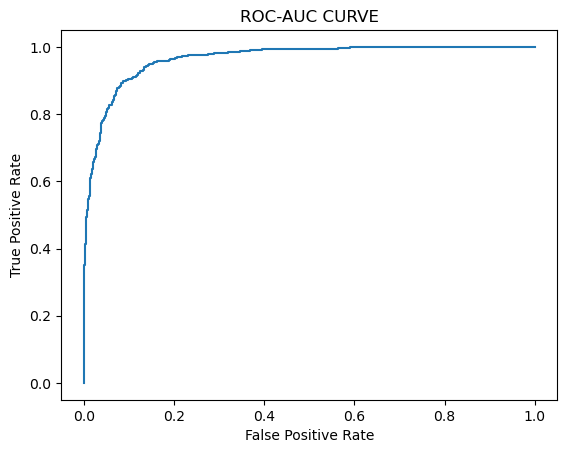

In [9]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC-AUC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

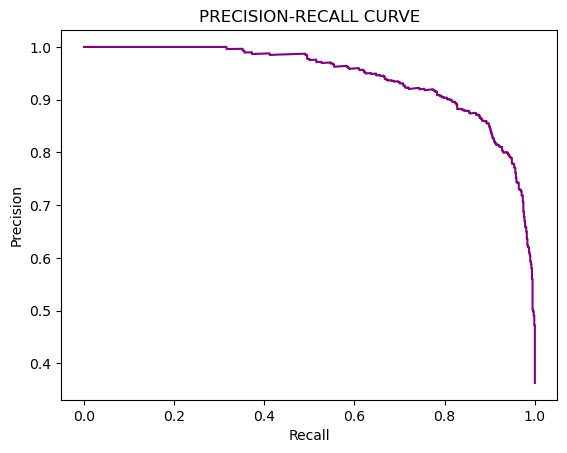

In [10]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
#create Precision-Recall curve
plt.plot(recall, precision, color='purple')
plt.title('PRECISION-RECALL CURVE')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

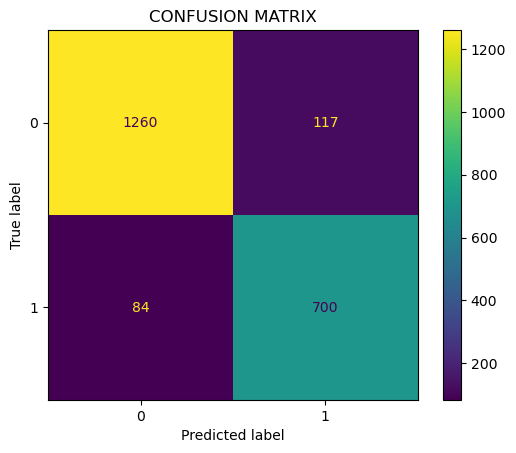

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot()
plt.title('CONFUSION MATRIX')
plt.show()

Additionally, we can visualize the relative importance of each feature for model prediction using the `plot_importance` function of XGBoost. Importance can be calculated based on: 'weight', 'gain' or 'cover'. Since we want to know which features are the ones that influence significantly in the predicitions, we'll use _gain_. **Gain** implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

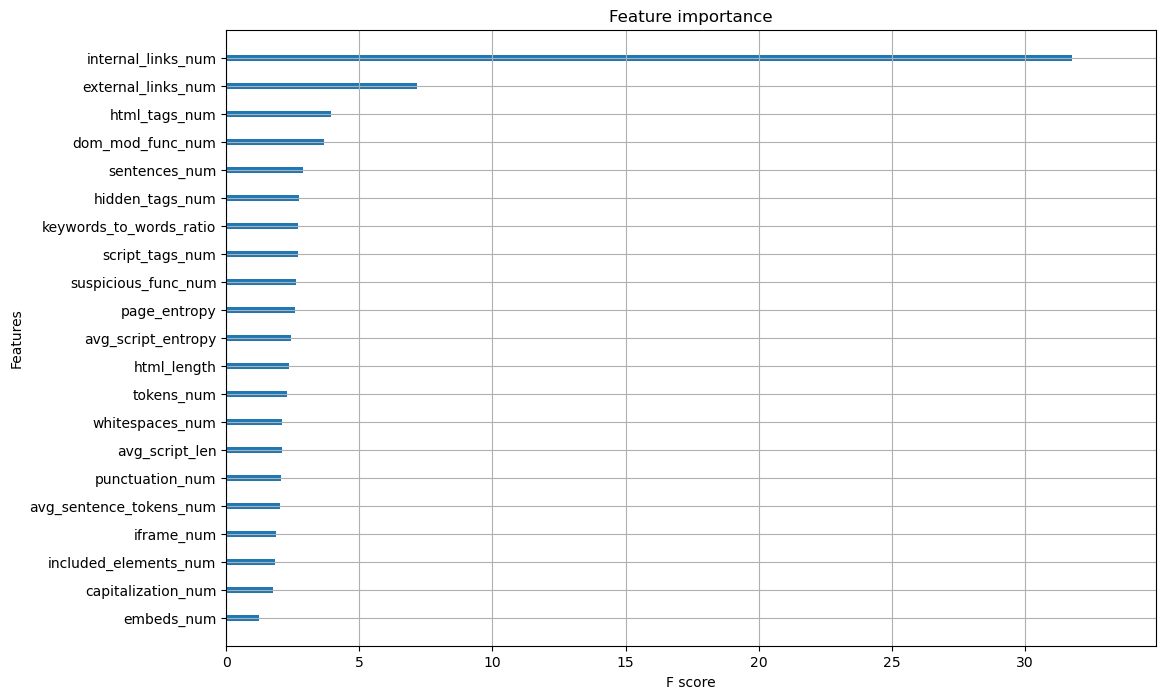

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model, ax=ax, importance_type='gain', show_values=False)
plt.show()

Based on this results, let's dig deeper in the most relevant features characteristics

In [13]:
# get 10 most relevant feautures
top_features = list({
    k: v for k, v in sorted(model.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1], reverse=True)
}.keys())[:10]

top_features

['internal_links_num',
 'external_links_num',
 'html_tags_num',
 'dom_mod_func_num',
 'sentences_num',
 'hidden_tags_num',
 'keywords_to_words_ratio',
 'script_tags_num',
 'suspicious_func_num',
 'page_entropy']

In [14]:
# calculate averages of each feature by class
stats = pd.concat([
    X_train.loc[y_train == 0][top_features].mean(axis=0),
    X_train.loc[y_train == 1][top_features].mean(axis=0)
], axis=1).round(2).rename(columns={0: 'Benign', 1:'Phishing'})
stats

,Benign,Phishing
internal_links_num,26.44,1.15
external_links_num,27.94,6.63
html_tags_num,362.30,128.42
dom_mod_func_num,7.33,4.03
sentences_num,237.96,158.02
hidden_tags_num,0.30,0.21
keywords_to_words_ratio,0.03,0.04
script_tags_num,14.98,6.24
suspicious_func_num,0.32,0.27
page_entropy,4.93,4.72


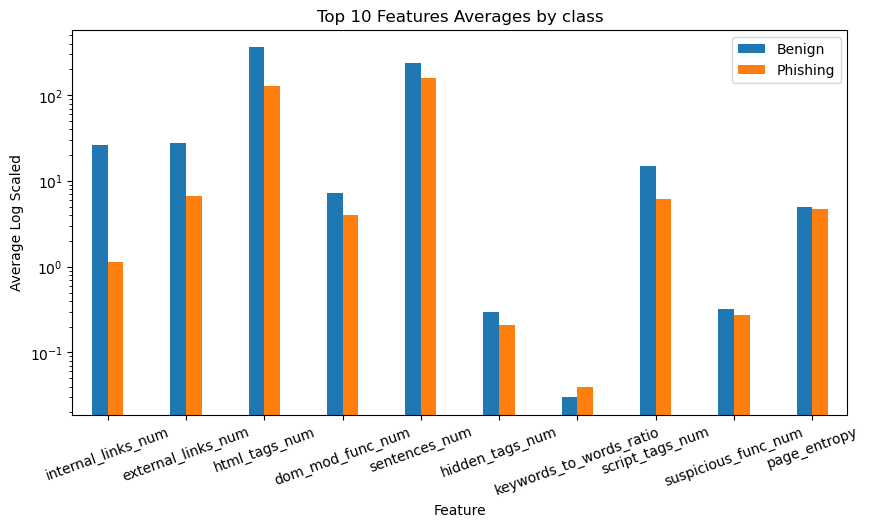

In [15]:
# plot features averages by class
stats.plot.bar(width=0.4, figsize=(10, 5))
plt.xlabel('Feature')
plt.ylabel('Average Log Scaled')
plt.title('Top 10 Features Averages by class')
plt.yscale('log')
plt.xticks(rotation=20)
plt.show() 